# Project Description and Goals

Natural Language Processing (NLP) uses programming & machine learning techniques to help understand and make use of large amounts of text data.


For this project, I will be scraping data from GitHub repository README files, that focus on the specific domain of social media, in order to build a model that can predict what programming language a repository is, given the text of the README file.

### Objectives for this project include:
- Building a dataset based on a list of GitHub repositories to scrape, and writing the python code necessary to extract the text of the README file for each page, and the primary language of the repository.
- Documenting process and analysis throughout the data science pipeline.
- Constructing a classification model that can predict what programming language a repository is in, given the text of the README file.
- Deliverables:
    - A well-documented jupyter notebook that contains my analysis.
    - One or two content slides suitable for a general audience that summarize findings with a well-labeled visualization included in slides.
    
### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial hypotheses
- What are the most frequently occuring words in READMEs per language?
- Are there any words that uniquely identify a programming language?
- What are the top word combinations (bigrams and trigrams)?

*** 
### Project Imports

In [1]:
import pandas as pd

#acquire and prep
from env import github_token, github_username
import acquire
import prepare

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#visualize
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings (turn off pink warning boxes)
import warnings
warnings.filterwarnings("ignore")

#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#train, validate, test
from sklearn.model_selection import train_test_split

#creating / evaluating models
# Decision Tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# K-Nearest Neighbor(KNN)  
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score

***
# Data Acquisition

In [2]:
#acquire data from acquire.py
df = pd.read_json('data.json')
df.head()

repo    language  \
0               sherlock-project/sherlock      Python   
1                 Greenwolf/social_mapper      Python   
2  bonzanini/Book-SocialMediaMiningPython      Python   
3                 qeeqbox/social-analyzer  JavaScript   
4                    anfederico/stocktalk      Python   

                                     readme_contents  
0  <p align=center>\n\n  <img src="https://user-i...  
1  # Social Mapper\n![alt text](https://img.shiel...  
2  Mastering Social Media Mining with Python\n===...  
3  <p align="center"> <img src="https://raw.githu...  
4  <p align="center"><img src="https://raw.github...

In [3]:
#rows and columns
df.shape

(150, 3)

In [4]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             150 non-null    object
 1   language         147 non-null    object
 2   readme_contents  150 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [5]:
#check value counts of languages
df.language.value_counts()

Python              33
JavaScript          28
PHP                 15
HTML                14
TypeScript           9
Jupyter Notebook     8
Java                 7
Dart                 7
CSS                  5
Ruby                 4
C#                   4
Shell                3
Objective-C          2
R                    2
Go                   1
Elixir               1
C++                  1
Scala                1
PostScript           1
TSQL                 1
Name: language, dtype: int64

In [6]:
#check nulls
df.isnull().sum()

repo               0
language           3
readme_contents    0
dtype: int64

### Findings
- There are 3 languages missing from repos that need to be dropped.
- Text from readme_contents needs to be cleaned, normalized, tokenized, lemmatized, have stopwords removed, etc. 
- Jupyter notebook can be turned into python programming language.
- There are a couple of languages with few value_counts that I will drop and will only keep top 5 languages.

***
# Data Preparation

In [7]:
#grab cleaned df from prepare.py
df = prepare.clean_content(df, 'readme_contents', extra_words = ['p', 'aligncenter', 'img'], exclude_words = ['no'])

#drop original readme_contents
df = df.drop(columns = ['readme_contents'])

df.head()

repo  \
0               sherlock-project/sherlock   
1                 Greenwolf/social_mapper   
2  bonzanini/Book-SocialMediaMiningPython   
3                 qeeqbox/social-analyzer   
4                    anfederico/stocktalk   

                                       clean_content    language  
0  srchttpsuserimagesgithubusercontentcom27065646...      Python  
1  social mapper alt texthttpsimgshieldsiobadgepy...      Python  
2  mastering social medium mining python code rep...      Python  
3  srchttpsrawgithubusercontentcomqeeqboxsocialan...  JavaScript  
4  aligncenterimg srchttpsrawgithubusercontentcom...      Python

In [8]:
#verify languages w/ fewer than 9 occurances were dropped and only kept 5
len(df.language.value_counts())

5

In [9]:
#check nulls
df.isnull().sum()

repo             0
clean_content    0
language         0
dtype: int64

In [10]:
#check how many words appear for each language and percentage
languages = pd.concat([df.language.value_counts(),
                    round(df.language.value_counts(normalize=True), 2)], axis=1)

languages.columns = ['n', 'percent']

languages

n  percent
Python      41     0.38
JavaScript  28     0.26
PHP         15     0.14
HTML        14     0.13
TypeScript   9     0.08

In [11]:
#check shape of prepped df
df.shape

(107, 3)

***
# Data Exploration

In [12]:
#breaking up data into each language

#words that appear in Python
python_words = ' '.join(df[df.language == 'Python'].clean_content)

#words that appear in JavaScript
javascript_words = ' '.join(df[df.language == 'JavaScript'].clean_content)

#words that appear in PHP
php_words = ' '.join(df[df.language == 'PHP'].clean_content)

#words that appear in HTML
html_words = ' '.join(df[df.language == 'HTML'].clean_content)

#words that appear in TypeScript
typescript_words = ' '.join(df[df.language == 'TypeScript'].clean_content)

#all of the words 
all_lang_words = ' '.join(df.clean_content)

In [13]:
#check how often each of the words occurs
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
all_lang_freq = pd.Series(all_lang_words.split()).value_counts()

print('Python:')
print(python_freq)
print('--------------------------')
print('JavaScript:')
print(javascript_freq)
print('--------------------------')
print('PHP:')
print(php_freq)
print('--------------------------')
print('HTML:')
print(html_freq)
print('--------------------------')
print('TypeScript:')
print(typescript_freq)
print('--------------------------')
print('All Languages:')
print(all_lang_freq)

Python:
&#9;        269
file        222
social      221
data        167
twitter     157
           ... 
reported      1
deployed      1
grabbing      1
beat          1
ali           1
Length: 5157, dtype: int64
--------------------------
JavaScript:
social            86
&#9;              78
run               78
use               76
default           75
                  ..
dataurlcontent     1
grant              1
membership         1
schedule           1
rafique            1
Length: 2761, dtype: int64
--------------------------
PHP:
&#9;                                98
user                                55
social                              51
twitter                             39
profile                             37
                                    ..
httpgithubcomabrahamtwitteroauth     1
visually                             1
news                                 1
ftp                                  1
kliksaadphp                          1
Length: 1410, dtype: int64
----

In [14]:
#combine frequencies together to get one resulting df
word_counts = (pd.concat([all_lang_freq, 
                          python_freq, 
                          javascript_freq, 
                          php_freq, 
                          html_freq, 
                          typescript_freq], axis=1, sort=True)
                .set_axis(['All', 
                           'Python', 
                           'JavaScript', 
                           'PHP', 
                           'HTML', 
                           'TypeScript'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8707 entries, &#9; to zuckerman
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   All         8707 non-null   int64
 1   Python      8707 non-null   int64
 2   JavaScript  8707 non-null   int64
 3   PHP         8707 non-null   int64
 4   HTML        8707 non-null   int64
 5   TypeScript  8707 non-null   int64
dtypes: int64(6)
memory usage: 476.2+ KB


In [15]:
word_counts.head()

All  Python  JavaScript  PHP  HTML  TypeScript
&#9;   463     269          78   98    18           0
0       22       6           4    2     4           6
000      1       1           0    0     0           0
0000    10      10           0    0     0           0
00000    1       1           0    0     0           0

### Takeaways:
- There is a lot of noise in each programming language
    - `&#9;`, single characters, and long strings appear frequently.

#### Additional cleanup to reduce noise

In [65]:
#remove `&#9;` characters
python_words = re.sub(r'&#9;', '', python_words)
javascript_words = re.sub(r'&#9;', '', javascript_words)
php_words = re.sub(r'&#9;', '', php_words)
html_words = re.sub(r'&#9;', '', html_words)
typescript_words = re.sub(r'&#9;', '', typescript_words)
all_lang_words = re.sub(r'&#9;', '', all_lang_words)

#remove single characters
python_words = re.sub(r'\s.\s', '', python_words)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
php_words = re.sub(r'\s.\s', '', php_words)
html_words = re.sub(r'\s.\s', '', html_words)
typescript_words = re.sub(r'\s.\s', '', typescript_words)
all_lang_words = re.sub(r'\s.\s', '', all_lang_words)

#remove words with 20 or more characters
python_words = re.sub(r'\b\w{20,}\b', '', python_words)
javascript_words = re.sub(r'\b\w{20,}\b', '', javascript_words)
php_words = re.sub(r'\b\w{20,}\b', '', php_words)
html_words = re.sub(r'\b\w{20,}\b', '', html_words)
typescript_words = re.sub(r'\b\w{20,}\b', '', typescript_words)
all_lang_words = re.sub(r'\b\w{20,}\b', '', all_lang_words)

#filter out all words that occur less than 20 times
word_counts = word_counts[word_counts['All'] >= 20]

In [66]:
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, &#9; to youtube
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   All         381 non-null    int64
 1   Python      381 non-null    int64
 2   JavaScript  381 non-null    int64
 3   PHP         381 non-null    int64
 4   HTML        381 non-null    int64
 5   TypeScript  381 non-null    int64
dtypes: int64(6)
memory usage: 20.8+ KB


In [67]:
word_counts.head(10)

All  Python  JavaScript  PHP  HTML  TypeScript
&#9;     463     269          78   98    18           0
0         22       6           4    2     4           6
1        166     114          24   12     7           9
2         93      59          18   10     6           0
3         78      48          14    7     9           0
4         52      31          10    6     5           0
5         45      27          10    5     2           1
6         25      15           4    3     2           1
access    60      38           8   14     0           0
account   97      62          12   15     1           7

In [68]:
word_counts.tail(10)

All  Python  JavaScript  PHP  HTML  TypeScript
width205px   22       0           0    0     0          22
window       51      35           8    4     0           4
without      56      22          13   10    11           0
wordpress    24       1           2   15     6           0
work         82      52          14    5     9           2
would        28      18           5    2     3           0
yarn         20       2           9    0     0           9
youll        25      14          10    0     1           0
youre        21      15           4    0     0           2
youtube      36      14          13    2     7           0

In [20]:
#double check how often each of the words occurs after additional cleanup
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
all_lang_freq = pd.Series(all_lang_words.split()).value_counts()

print('Python:')
print(python_freq)
print('--------------------------')
print('JavaScript:')
print(javascript_freq)
print('--------------------------')
print('PHP:')
print(php_freq)
print('--------------------------')
print('HTML:')
print(html_freq)
print('--------------------------')
print('TypeScript:')
print(typescript_freq)
print('--------------------------')
print('All Languages:')
print(all_lang_freq)

Python:
social                 218
file                   218
data                   165
twitter                146
python                 142
                      ... 
countvectorizer          1
mailtojeffamazoncom      1
altbook                  1
flatten                  1
ali                      1
Length: 4468, dtype: int64
--------------------------
JavaScript:
social          85
run             75
use             73
default         72
profile         64
                ..
defaultlogo      1
checkirc         1
clientside       1
callbacknull     1
usersuserid      1
Length: 2362, dtype: int64
--------------------------
PHP:
user              52
social            51
twitter           38
profile           37
medium            30
                  ..
caption            1
send               1
usersviewphpna     1
licensed           1
improve            1
Length: 1289, dtype: int64
--------------------------
HTML:
button                98
share                 78
icon                

### What are the most frequently occuring words in READMEs per language?

In [21]:
#getting top word counts and sorting the values
word_counts.sort_values(by='All', ascending=False).head(10)

All  Python  JavaScript  PHP  HTML  TypeScript
&#9;     463     269          78   98    18           0
social   421     221          86   51    44          19
file     330     222          45   28    31           4
medium   296     140          61   30    51          14
twitter  275     157          45   39    23          11
run      249     134          78    4     7          26
use      249     112          76   20    26          15
data     235     167          42   10    15           1
user     227     115          36   55    11          10
install  200     102          73    5    10          10

#### Takeaways
- Common words such as 'social' and 'twitter' make sense, since the project is focusing on social media repos.
- Unsure `&#9;` is common throughout all the languages, with exception of TypeScript.
- Python seems to have the most word counts of all the other programming languages.

### Are there any words that uniquely identify a programming language?

In [22]:
#concat the word counts for each programming language into a df
pd.concat([word_counts[word_counts.Python == 0].sort_values(by='Python').head(10),
           word_counts[word_counts.JavaScript == 0].sort_values(by='JavaScript').head(10), 
           word_counts[word_counts.PHP == 0].sort_values(by='PHP').head(10), 
           word_counts[word_counts.HTML == 0].sort_values(by='HTML').head(10), 
           word_counts[word_counts.TypeScript == 0].sort_values(by='TypeScript').head(10)])

All  Python  JavaScript  PHP  HTML  \
cs                                    31       0          14    4    12   
font                                  26       0          14    0     4   
jquery                                22       0          20    2     0   
nodejs                                32       0          27    0     0   
php                                   27       0           0   22     5   
plugin                                38       0          19   19     0   
sharersocialsharetextstringfalseset   23       0           0    0    23   
sharersocialshareurlurlpage           22       0           0    0    22   
urlset                                23       0           0    0    23   
var                                   25       0          25    0     0   
alternative                           20       3           0    1    15   
urlset                                23       0           0    0    23   
unified                               34      34           0    0     0   
sharersocialshareurlurlpage           22       0           0    0    22   
sharersocialsharetextstringfalseset   23       0           0    0    23   
sentiment                             21      21           0    0     0   
scrape                                28      27           0    0     1   
removed                               31       9           0    1    21   
regex                                 48      47           0    0     1   
weibo                                 20      18           0    0     1   
alt                                   33      10           1    0    22   
sharersocialsharetextstringfalseset   23       0           0    0    23   
sentiment                             21      21           0    0     0   
second                                23      10          10    0     3   
scrape                                28      27           0    0     1   
return                                22       7          10    0     2   
requirementstxt                       20      16           3    0     1   
repo                                  44      33           8    0     2   
render                                21       1          13    0     0   
regex                                 48      47           0    0     1   
access                                60      38           8   14     0   
jupyter                               20      20           0    0     0   
keywords                              20      15           0    2     0   
library                               43      22          10    3     0   
local                                 40      25          10    3     0   
log                                   28      15          11    2     0   
login                                 23      11           2   10     0   
mapper                                22      22           0    0     0   
metadata                              20       3          17    0     0   
mode                                  25      12           8    1     0   
&#9;                                 463     269          78   98    18   
result                                67      52           7    4     4   
requires                              24      15           3    5     1   
requirementstxt                       20      16           3    0     1   
removed                               31       9           0    1    21   
regex                                 48      47           0    0     1   
r                                     33      22           5    2     4   
python3                               45      39           6    0     0   
python                               181     154          19    0     8   
put                                   22      17           3    0     2   

                                     TypeScript  
cs                                            1  
font                                          8  
jquery                                        0  
nodejs     

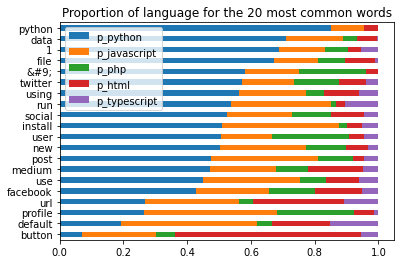

In [23]:
#visualize percentage for each language
(word_counts
 .assign(p_python=word_counts.Python / word_counts['All'],
         p_javascript=word_counts.JavaScript / word_counts['All'], 
         p_php=word_counts.PHP / word_counts['All'], 
         p_html=word_counts.HTML / word_counts['All'], 
         p_typescript=word_counts.TypeScript / word_counts['All'])
 .sort_values(by='All')
 [['p_python', 'p_javascript', 'p_php', 'p_html', 'p_typescript']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')
plt.show()

#### Takeaways
- Some words do uniquely identify programming languages
    - 'jupyter, unified, sentiment, scrape, regex, repo, data, social, install' appear most frequently in Python
    - 'button' appears the most in html according to the bar plot.
    - 'plugin' only appears in JavaScript and PHP.
    - HTML contains many words that are strung together (i.e. sharersocialshareurlurlpage).
    - 'var' only appears in JavaScript.

### What are the top word combinations (bigrams and trigrams)?

In [24]:
#variables for most common Bigrams for each language
python_bigrams = (pd.Series(nltk.ngrams(python_words.split(), 2))
                      .value_counts()
                      .head(20))
javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 2))
                      .value_counts()
                      .head(20))
php_bigrams = (pd.Series(nltk.ngrams(php_words.split(), 2))
                      .value_counts()
                      .head(20))
html_bigrams = (pd.Series(nltk.ngrams(html_words.split(), 2))
                      .value_counts()
                      .head(20))
typescript_bigrams = (pd.Series(nltk.ngrams(typescript_words.split(), 2))
                      .value_counts()
                      .head(20))
all_bigrams = (pd.Series(nltk.ngrams(all_lang_words.split(), 2))
                      .value_counts()
                      .head(20))

In [25]:
#variables for most common Trigrams for each category
python_trigrams = (pd.Series(nltk.ngrams(python_words.split(), 3))
                      .value_counts()
                      .head(20))
javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))
php_trigrams = (pd.Series(nltk.ngrams(php_words.split(), 3))
                      .value_counts()
                      .head(20))
html_trigrams = (pd.Series(nltk.ngrams(html_words.split(), 3))
                      .value_counts()
                      .head(20))
typescript_trigrams = (pd.Series(nltk.ngrams(typescript_words.split(), 3))
                      .value_counts()
                      .head(20))
all_trigrams = (pd.Series(nltk.ngrams(all_lang_words.split(), 3))
                      .value_counts()
                      .head(20))

### Python Bigrams / Trigrams and Word Clouds

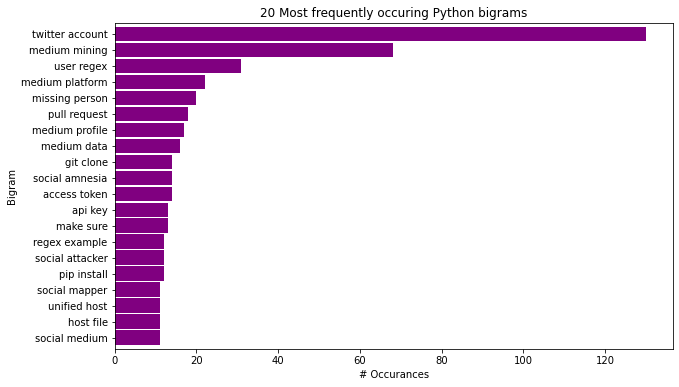

In [26]:
#bigrams
python_bigrams.sort_values().plot.barh(color='purple', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

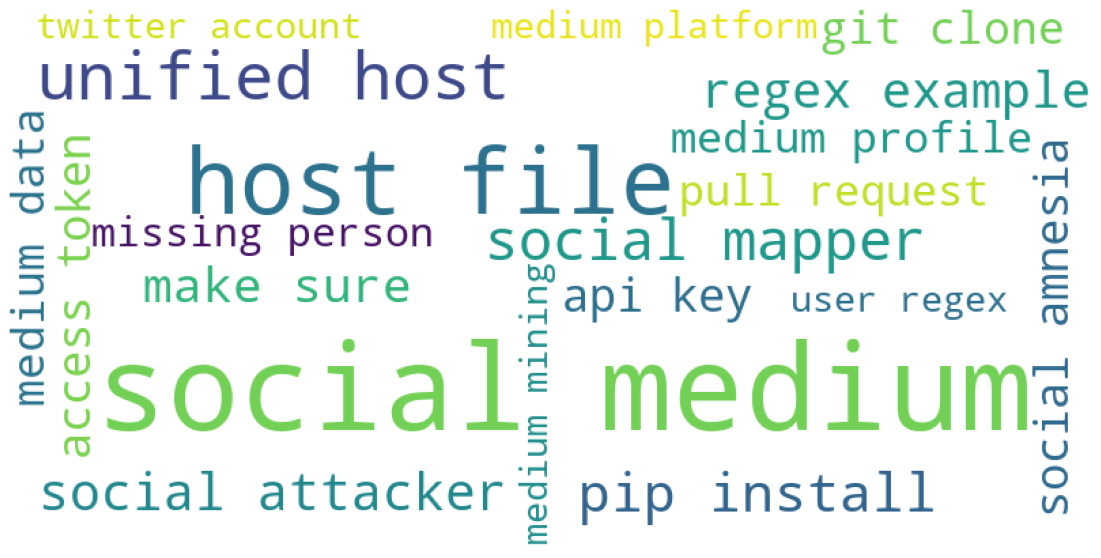

In [27]:
#use python bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

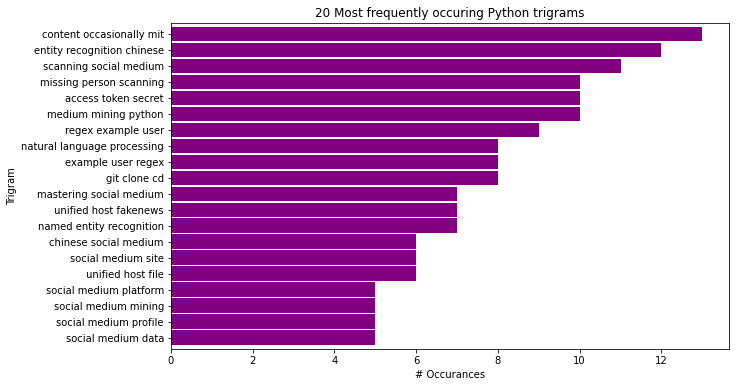

In [28]:
#trigrams
python_trigrams.sort_values().plot.barh(color='purple', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

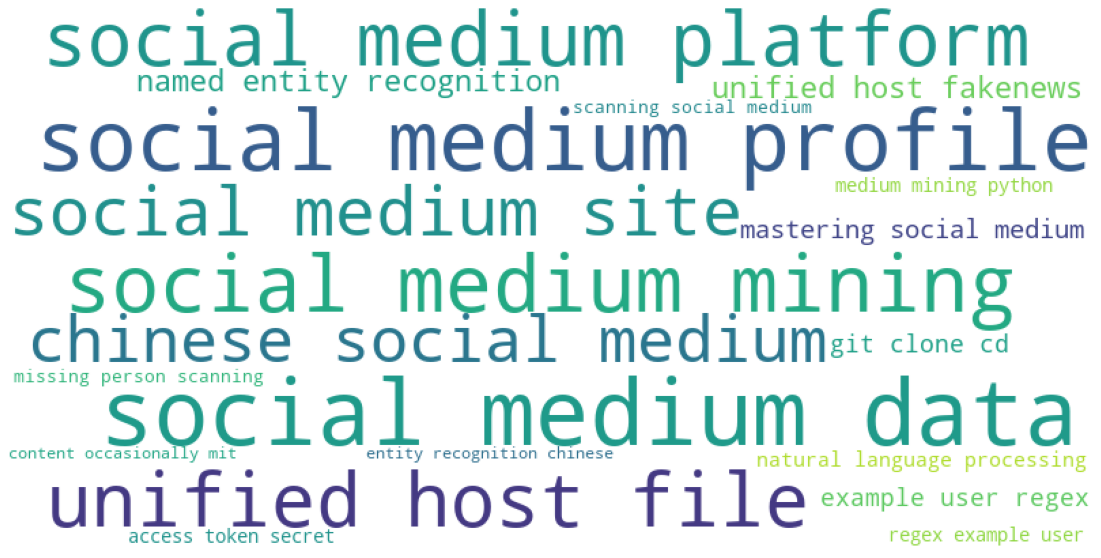

In [29]:
#use python trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### JavaScript Bigrams / Trigrams and Word Clouds

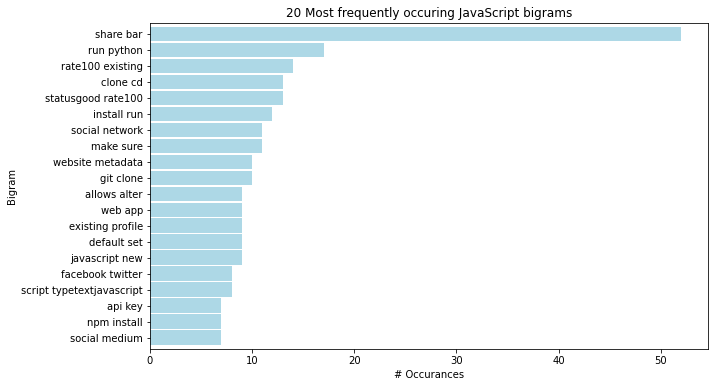

In [30]:
#bigrams
javascript_bigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = javascript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

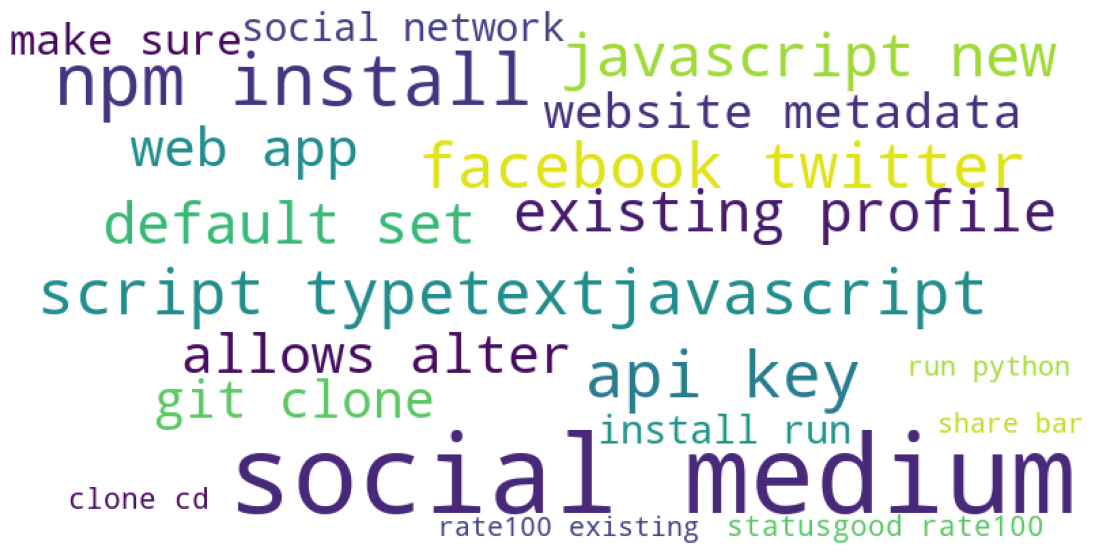

In [31]:
#use javascript bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

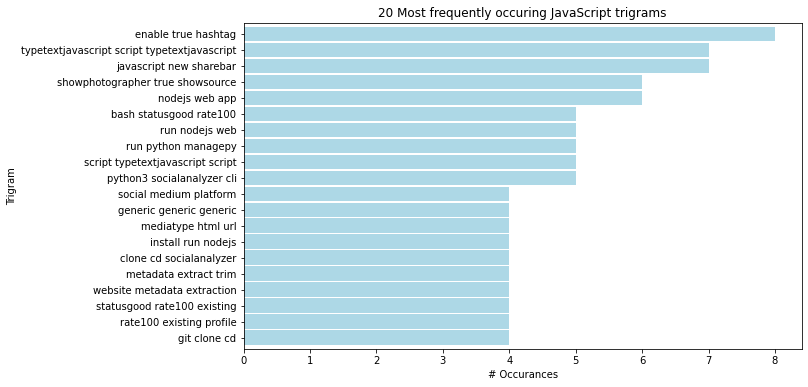

In [32]:
#trigrams
javascript_trigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = javascript_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

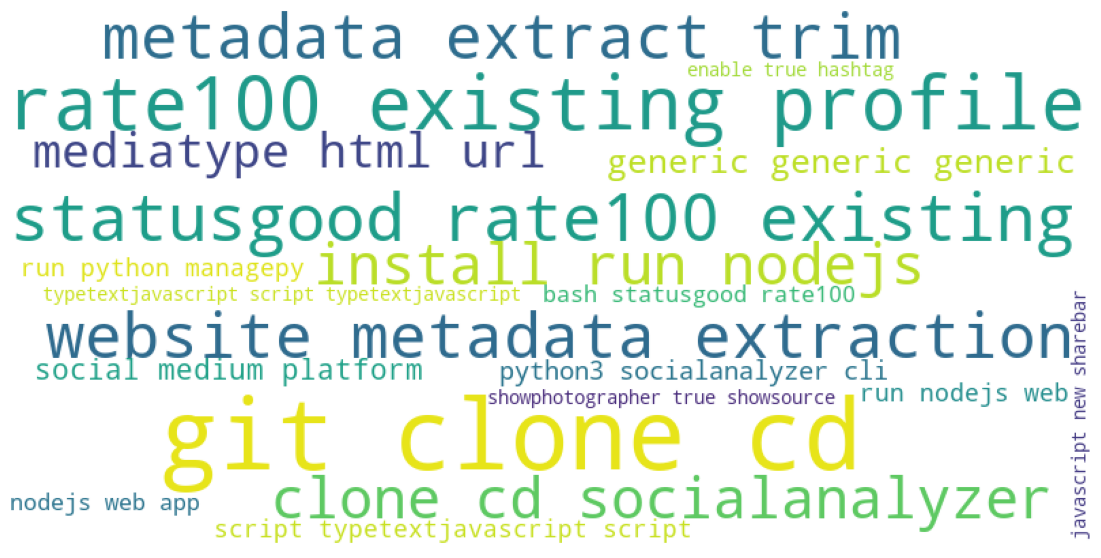

In [33]:
#use JavaScript trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### PHP Bigrams / Trigrams and Word Clouds

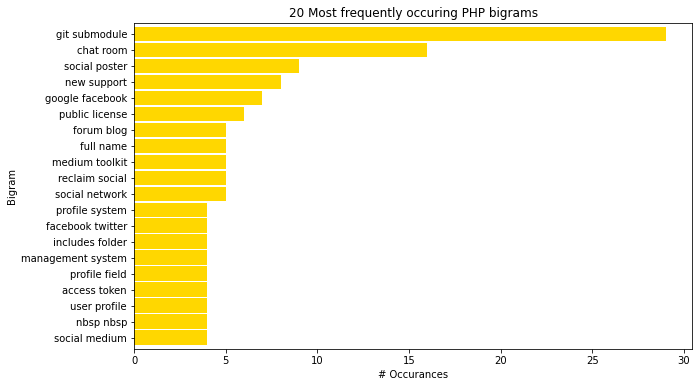

In [34]:
#bigrams
php_bigrams.sort_values().plot.barh(color='gold', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring PHP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = php_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


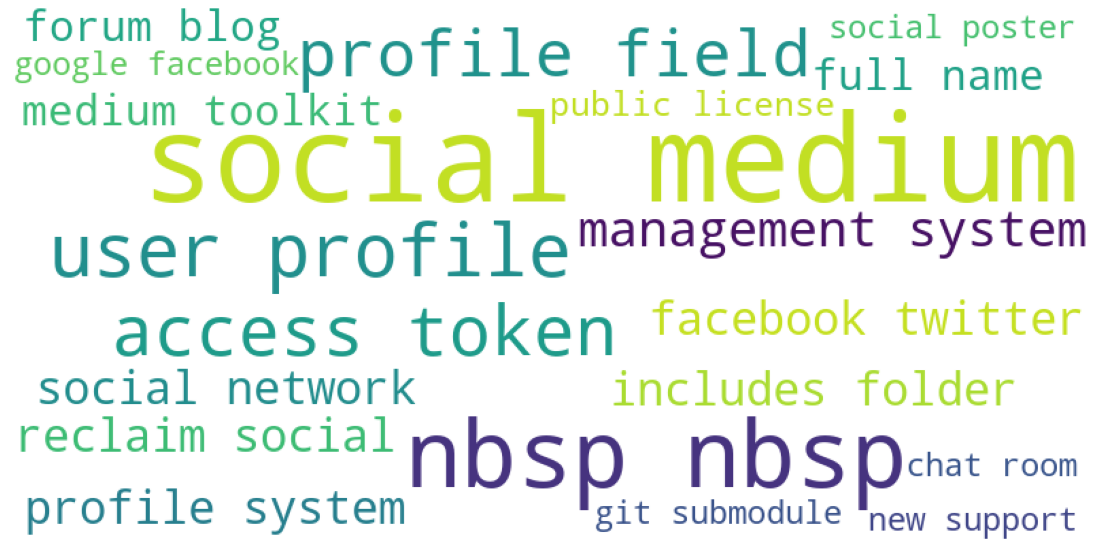

In [35]:
#use php bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in php_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

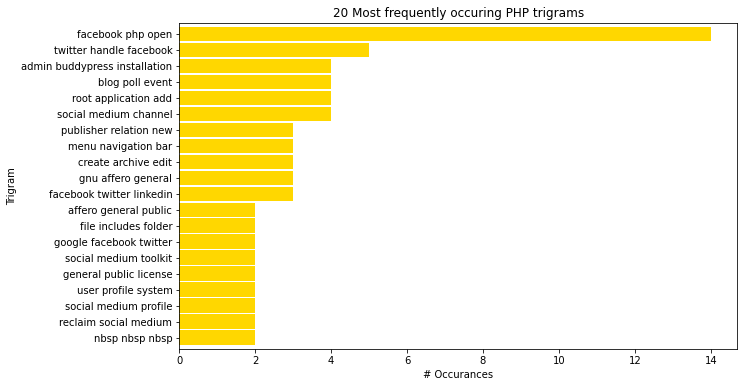

In [36]:
#trigrams
php_trigrams.sort_values().plot.barh(color='gold', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring PHP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = php_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

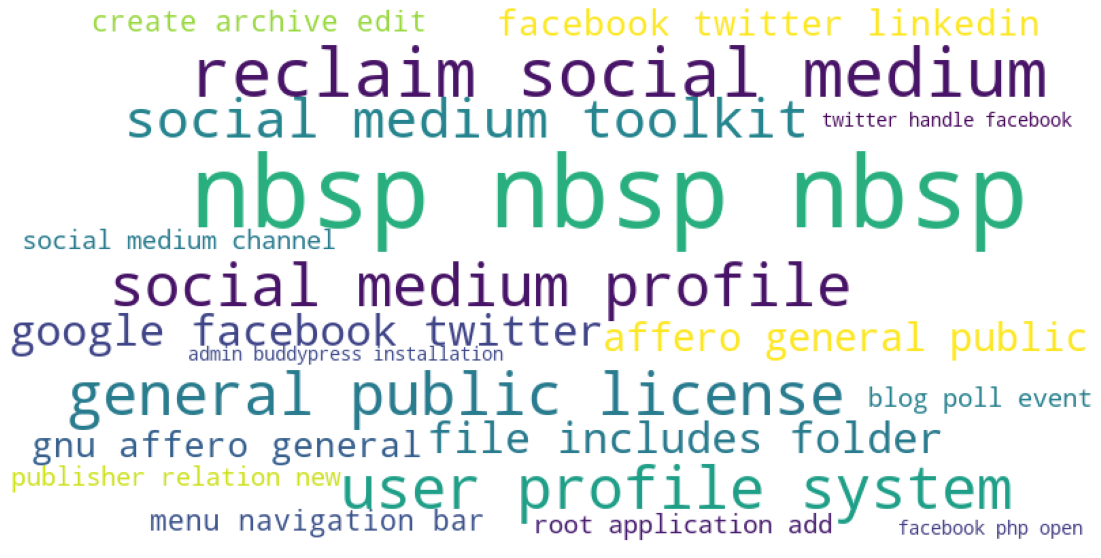

In [37]:
#use php trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in php_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### HTML Bigrams / Trigrams and Word Clouds

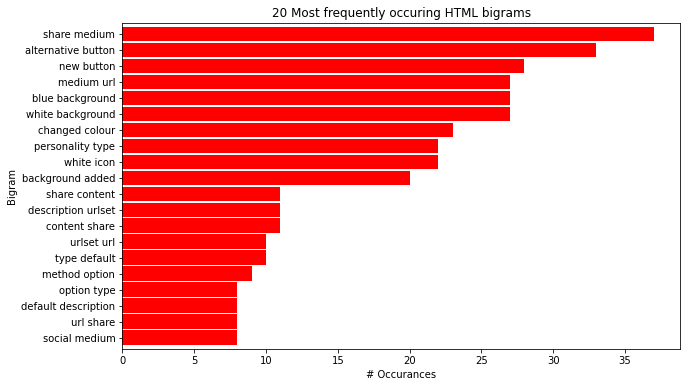

In [38]:
#bigrams
html_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

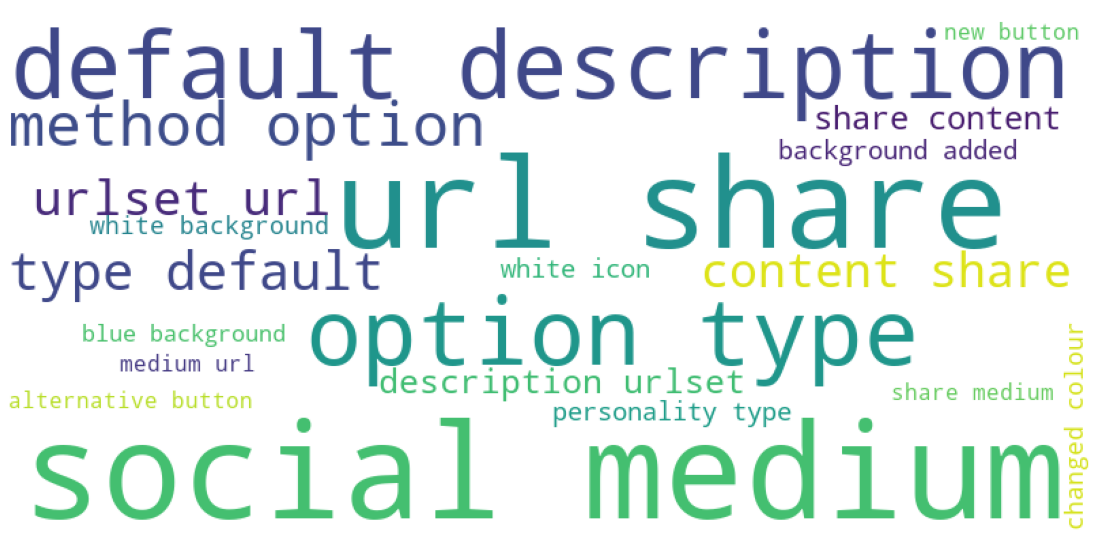

In [39]:
#use html bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

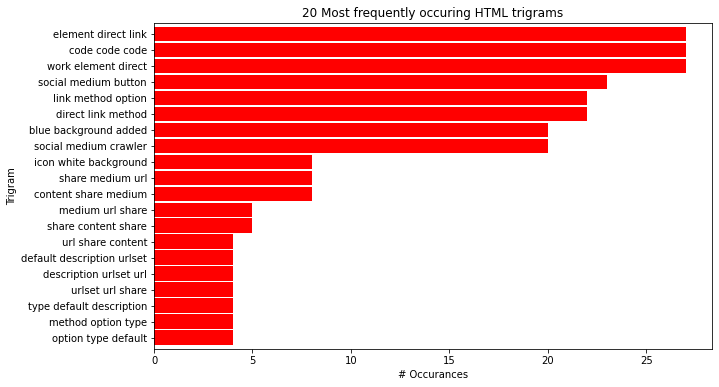

In [40]:
#trigrams
html_trigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = html_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

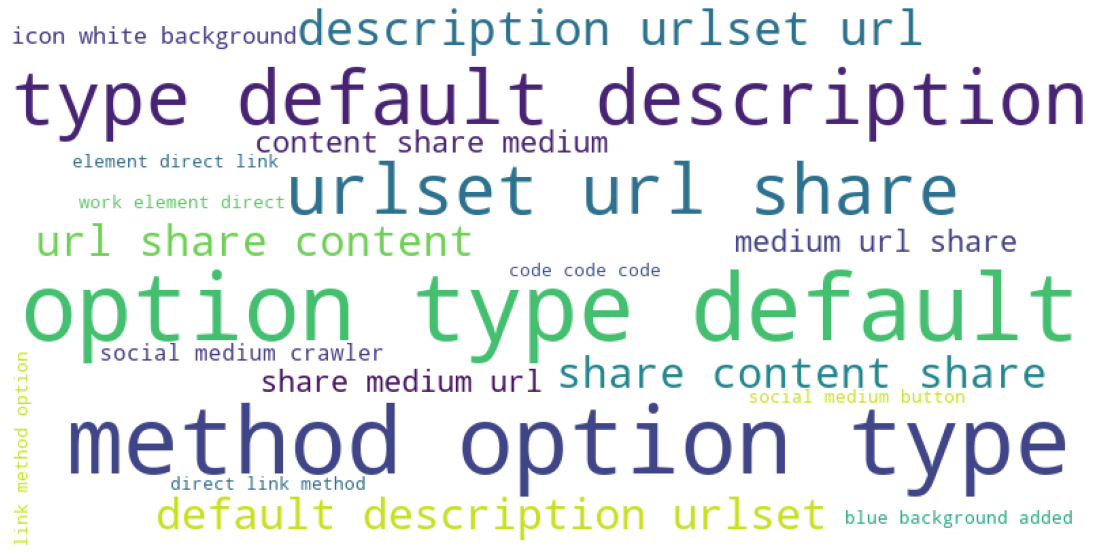

In [41]:
#use html trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in html_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### TypeScript Bigrams / Trigrams and Word Clouds

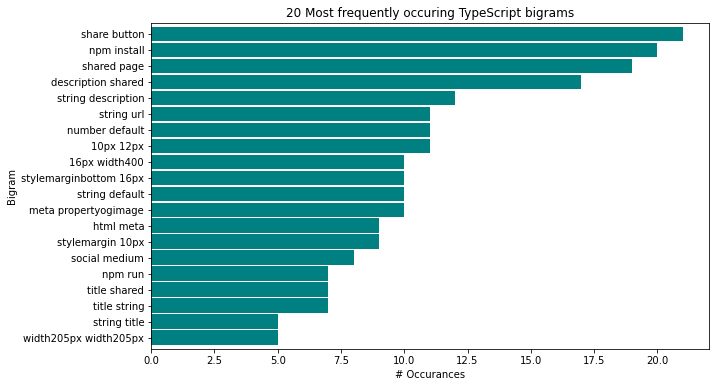

In [42]:
#bigrams
typescript_bigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TypeScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = typescript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

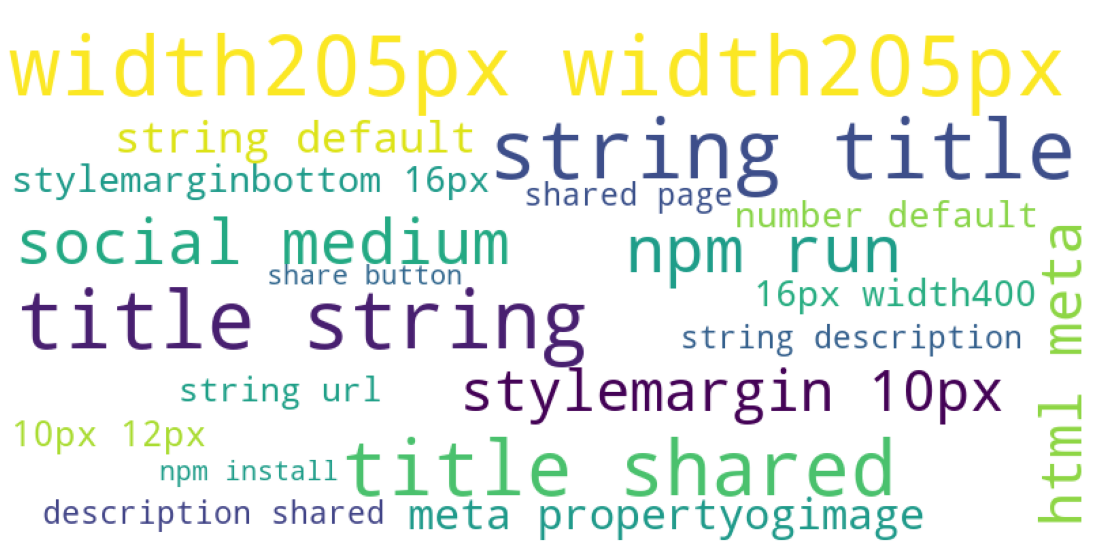

In [43]:
#use typescript bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in typescript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

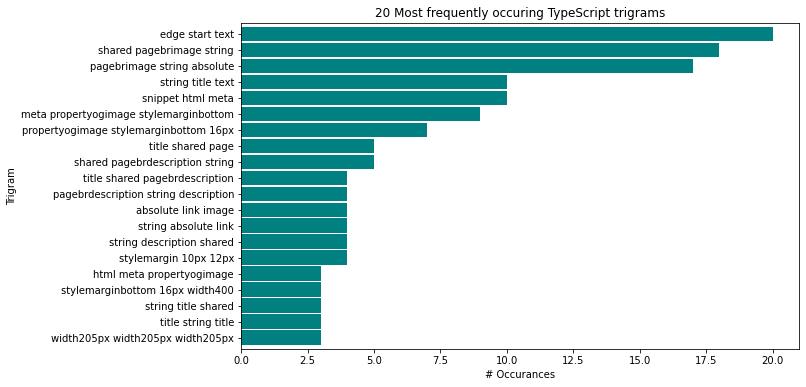

In [44]:
#trigrams
typescript_trigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TypeScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = typescript_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

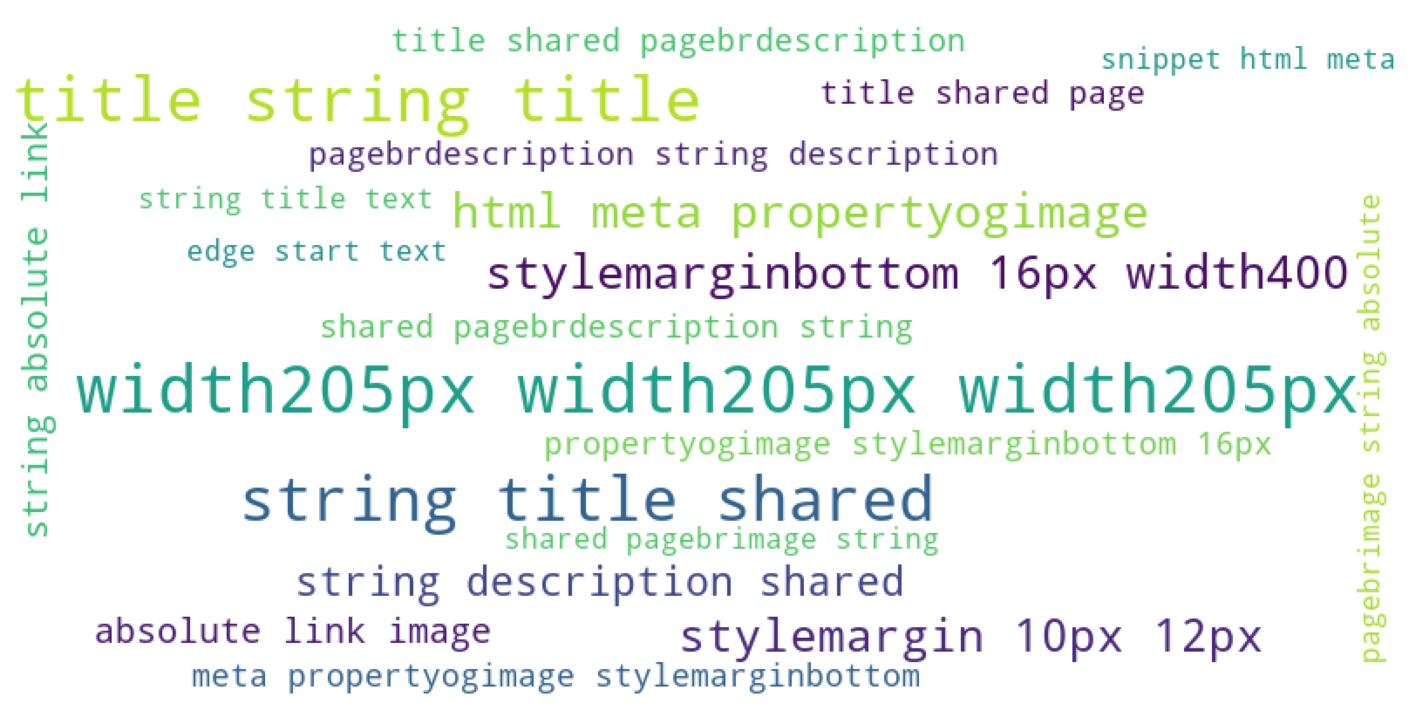

In [45]:
#use typescript trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in typescript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(25, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

### All Programming Languages Bigrams / Trigrams and Word Clouds

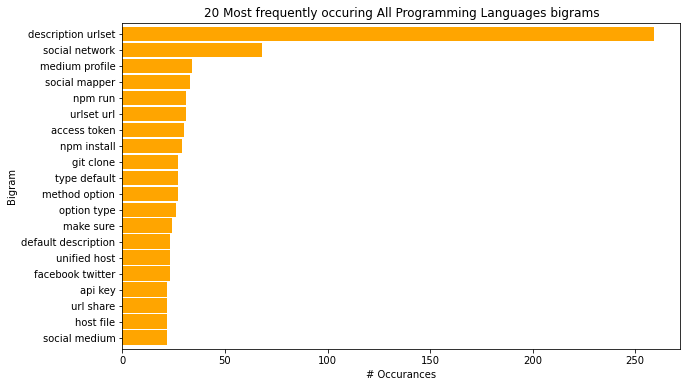

In [46]:
#bigrams
all_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring All Programming Languages bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = all_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

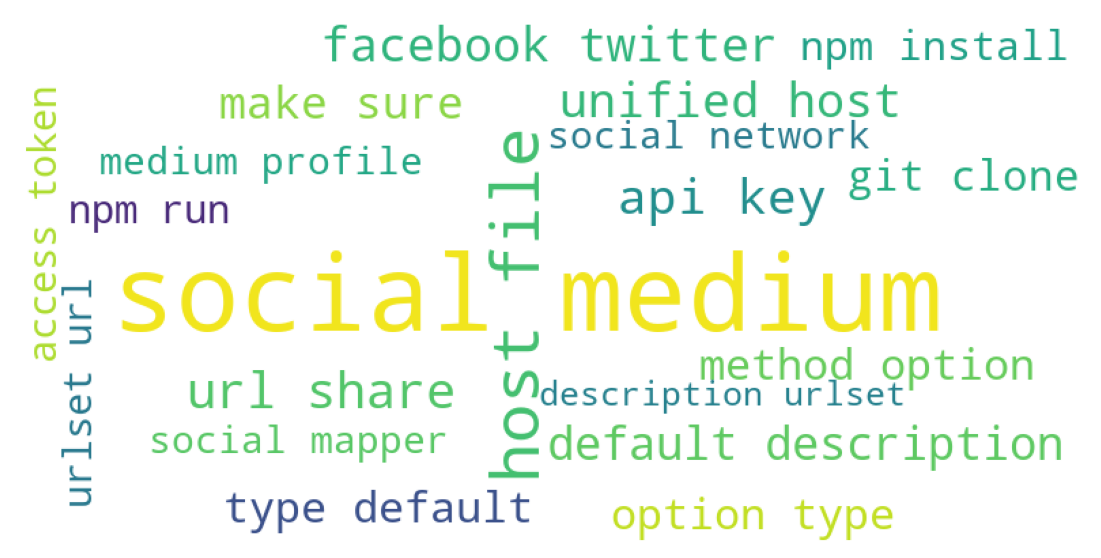

In [47]:
#use all bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

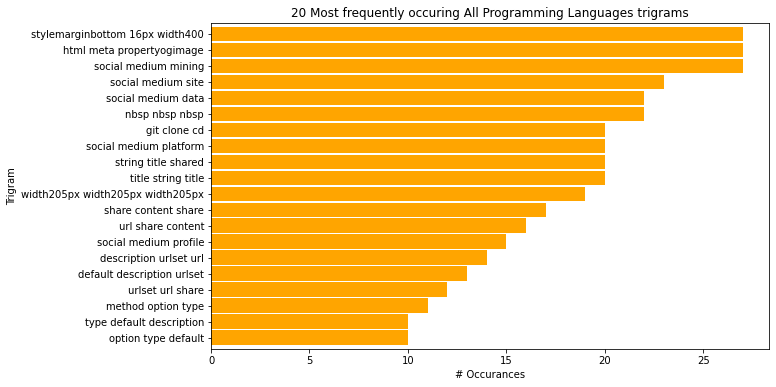

In [48]:
#trigrams
all_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring All Programming Languages trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = all_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

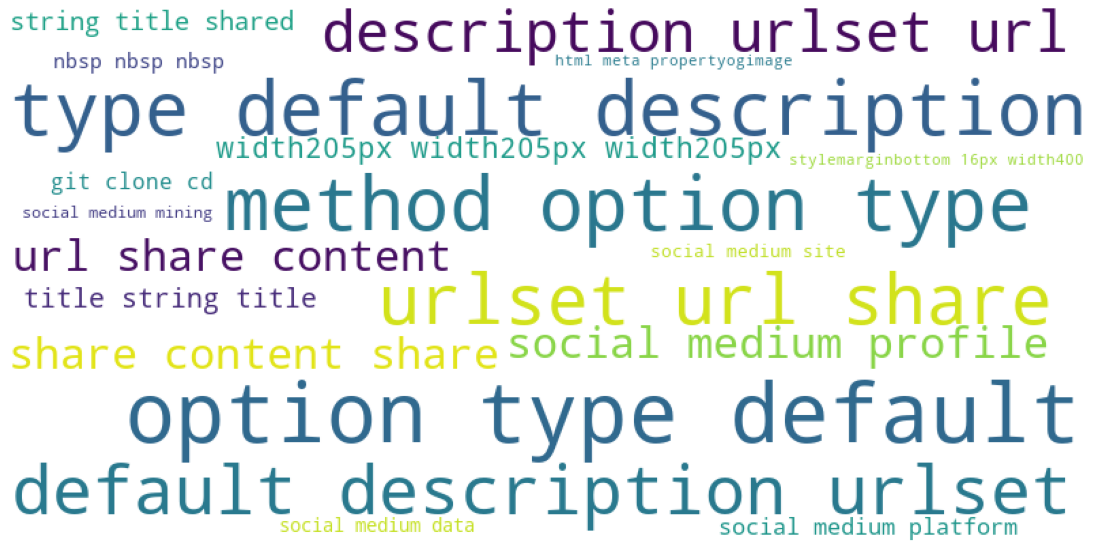

In [49]:
#use all trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in all_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

***
# Data Modeling and Evaluation

In [50]:
#split the data by using split function from prepare.py
train, validate, test = prepare.split(df, 'language')
train.head()

repo  \
14              pablobarbera/social-media-workshop   
118  socialmedia-class/socialmedia-class.github.io   
78                   HDMA-SDSU/HDMA-SocialMediaAPI   
102                   fluquid/extract-social-media   
19         openstream/open-social-media-monitoring   

                                         clean_content language  
14   workshop collecting analyzing social medium da...     HTML  
118  socialmediaclassgithubio social medium text an...     HTML  
78   social medium api project conducted san diego ...     HTML  
102  extract social medium image httpsimgshieldsiop...   Python  
19   installation upload file onto server upload ei...      PHP

In [52]:
#setup X variables
X_train = train.clean_content
X_validate = validate.clean_content
X_test = test.clean_content

#setup y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [53]:
#baseline prediction: the most prevalent class in training dataset(the mode)
train.language.value_counts()

Python        23
JavaScript    15
HTML           8
PHP            8
TypeScript     5
Name: language, dtype: int64

In [54]:
#baseline model would be to predict python since it is most prevalant
#baseline accuracy:
baseline_accuracy = (train.language == 'Python').mean()

print(f'baseline accuracy: {baseline_accuracy: .2}')

baseline accuracy:  0.39


In [55]:
#Create the tfidf vectorizer object 
tfidf = TfidfVectorizer()

#Fit on the training data
tfidf.fit(X_train)

#Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

X_train_vectorized

<59x5940 sparse matrix of type '<class 'numpy.float64'>'
	with 13196 stored elements in Compressed Sparse Row format>

In [56]:
#check out the shape of tfidf vectorizer object
X_train_vectorized.todense().shape

(59, 5940)

In [57]:
#Decision Tree model
dt = DecisionTreeClassifier(max_depth=3, random_state=123)

#fit model
dt.fit(X_train_vectorized, y_train)

#get predictions from model
y_pred = dt.predict(X_train_vectorized)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy: {:.2f}'
     .format(dt.score(X_train_vectorized, y_train)))

Baseline is 0.39
----------------
Accuracy: 0.78


In [58]:
#Random forest model 
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state=123)

#fit model
rf = rf.fit(X_train_vectorized, y_train)

#get predictions from model
y_pred = rf.predict(X_train_vectorized)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy: {:.2f}'
     .format(rf.score(X_train_vectorized, y_train)))

Baseline is 0.39
----------------
Accuracy: 0.86


In [59]:
#K-Nearest Neighbor model
knn = KNeighborsClassifier(n_neighbors=20)

#fit model
knn = knn.fit(X_train_vectorized, y_train)

#get predictions from model
y_pred = knn.predict(X_train_vectorized)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy: {:.2f}'
     .format(knn.score(X_train_vectorized, y_train)))

Baseline is 0.39
----------------
Accuracy: 0.51


In [60]:
#Logistic regression model 
logit = LogisticRegression(random_state=123)

#fit model
logit.fit(X_train_vectorized, y_train)

#get predictions from model
y_pred = logit.predict(X_train_vectorized)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy: {:.2f}'
     .format(logit.score(X_train_vectorized, y_train)))

Baseline is 0.39
----------------
Accuracy: 0.80


### Top 3 Models on training data:
- Random forest with score of 86%.
- Logistic regression with score of 80%.
- Decision tree with score of 78%.


Next, compare scores to validate (out-of-sample data).

In [61]:
#rf's metrics on validate
#evaluate on validate sample
y_pred = rf.predict(X_validate_vectorized)

#compare train to validate
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_vectorized, y_train)))
print("--------------------------------------------------------------")
print("Random Forest classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Random Forest classifier on training set: 0.86
--------------------------------------------------------------
Random Forest classifier on validate set:
              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         3
  JavaScript       0.50      0.29      0.36         7
         PHP       0.00      0.00      0.00         4
      Python       0.42      0.80      0.55        10
  TypeScript       0.00      0.00      0.00         2

    accuracy                           0.38        26
   macro avg       0.18      0.22      0.18        26
weighted avg       0.30      0.38      0.31        26



In [62]:
#logit's metrics on validate
#evaluate on validate sample
y_pred = logit.predict(X_validate_vectorized)

#compare train to validate
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_vectorized, y_train)))
print("--------------------------------------------------------------")
print("Logistic Regression classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.80
--------------------------------------------------------------
Logistic Regression classifier on validate set:
              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         3
  JavaScript       0.50      0.14      0.22         7
         PHP       0.00      0.00      0.00         4
      Python       0.42      1.00      0.59        10
  TypeScript       0.00      0.00      0.00         2

    accuracy                           0.42        26
   macro avg       0.18      0.23      0.16        26
weighted avg       0.29      0.42      0.29        26



In [63]:
#dt's metrics on validate
#evaluate on validate sample
y_pred = dt.predict(X_validate_vectorized)

#compare train to validate
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dt.score(X_train_vectorized, y_train)))
print("--------------------------------------------------------------")
print("Decision Tree classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Decision Tree classifier on training set: 0.78
--------------------------------------------------------------
Decision Tree classifier on validate set:
              precision    recall  f1-score   support

        HTML       0.20      0.33      0.25         3
  JavaScript       0.38      0.71      0.50         7
         PHP       0.00      0.00      0.00         4
      Python       1.00      0.70      0.82        10
  TypeScript       0.00      0.00      0.00         2

    accuracy                           0.50        26
   macro avg       0.32      0.35      0.31        26
weighted avg       0.51      0.50      0.48        26



### Top Validation Model to move forward with Test:
- Decision tree with score of 50%.

In [64]:
#evaluate on test sample 
y_pred_test = dt.predict(X_test_vectorized)

print("Decision Tree Model:")
print(classification_report(y_test, y_pred_test))

Decision Tree Model:
              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         3
  JavaScript       0.45      0.83      0.59         6
         PHP       0.00      0.00      0.00         3
      Python       0.67      0.75      0.71         8
  TypeScript       0.00      0.00      0.00         2

    accuracy                           0.50        22
   macro avg       0.22      0.32      0.26        22
weighted avg       0.37      0.50      0.42        22



***
# Conclusion
### Takeaways
- The best performing model uses a Decision Tree algorithm and TF-IDF to vectorize the text. 
- The model increased from a baseline accuracy of 38% to 50% accuracy on out-of-sample data.
- It appears that the models are overfit as they performed well on training data initially. However, the models' accuracies significantly decreased when testing on validate (out-of-sample) data. 
- Additionally, it seems that the models do not do a good job in predicting programming languages like HTML, PHP, and TypeScript.
- However, the final Decision Tree model does do a good job in predicting if the text from a GitHub repository's README file is either Python or JavaScript. 
- As the report shows, it is also evident that README files for Python are better predictors than for JavaScript. 


### Next Steps
- Gather higher quantity of READMEs from GitHub repositories.
- Create new features by implementing feature engineering.
- Run statistical testing.
- Conduct more modeling. 



#### Report containing summarization of findings can be found [here](link to google slides).